In [2]:
!pip install -q 'git+https://github.com/facebookresearch/detectron2.git'

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.5 MB/s eta 0:00:00


In [3]:
!pip -q install pycocotools tqdm


from google.colab import drive
drive.mount('/content/drive')


import os, glob, json, random, shutil, zipfile
import numpy as np
import cv2
from tqdm import tqdm

import torch
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
import pycocotools.mask as mask_util

Mounted at /content/drive


In [4]:
# ==== Paths & global params ====
DRIVE_ROOT = "/content/drive/MyDrive"

# Teacher (Loranthus-only) segmentation weights
WEIGHTS = f"{DRIVE_ROOT}/pollen_crops/model_final.pth"
assert os.path.isfile(WEIGHTS), "Weights not found. Please check the path!"

# Species used throughout (COCO categories will follow this order)
SPECIES = ["loranthus", "alnus", "carpinus"]

# Per-species crop root pattern (as on Drive)
DATA_ROOT_FMT = DRIVE_ROOT + "/pollen_crops/{sp}_0.5/{sp}_0.5 copy"

# Output root for COCO pseudo-label assets
OUT_ROOT = DRIVE_ROOT + "/pollen_segmentation"
os.makedirs(OUT_ROOT, exist_ok=True)

# COCO filenames (mask-based, top-1 per image, low-threshold harvest)
MASTER_JSON = "coco_thr001_top1_masks.json"
PKG_ZIP = "/content/coco_thr001_top1_masks_package.zip"
PKG_ZIP_DRIVE = os.path.join(OUT_ROOT, os.path.basename(PKG_ZIP))

# ==== Detection/selection policy (Python-side filtering) ====
THR = 0.01                 # primary score threshold before top-k
TOP1_PER_IMAGE = True      # keep at most 1 detection per image
FALLBACK_TOP1 = True       # if none ≥ THR, keep the single best if ≥ MIN_SCORE_FLOOR
MIN_SCORE_FLOOR = 0.01     # minimal score to allow fallback

# --- Light mask-level cleaning ---
USE_AREA_RATIO_FILTER = True
MIN_AREA_RATIO = 0.02      # reject masks smaller than 2% of image area
MAX_AREA_RATIO = 0.95      # reject masks larger than 95% of image area

USE_BORDER_TOUCH = True
BORDER_FRAC = 0.02         # border band width (as fraction of image size)
BORDER_RULE_STRICT_EDGES = 2  # drop if the mask touches ≥2 image edges
BORDER_RULE_BIG_ONE = 0.90    # or if area_ratio > 0.9 and it touches ≥1 edge

MIN_SHORT_SIDE = 24        # drop boxes with min(h, w) < 24 px

# Train/Val/Test split (percentages sum to 100)
SPLIT = {"train": 85, "val": 10, "test": 5}

# Reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED)

# COCO category ids (start from 1)
species_to_cat = {sp: i + 1 for i, sp in enumerate(SPECIES)}

# ==== Detectron2 predictor (Teacher, 1-class) ====
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1      # teacher is single-class (loranthus)
cfg.MODEL.WEIGHTS = WEIGHTS
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.0  # return all; we filter in Python

predictor = DefaultPredictor(cfg)
print("Predictor ready.")

Predictor ready.


In [5]:
def iter_species_files(sp):
    root = DATA_ROOT_FMT.format(sp=sp)
    files = []
    for ext in ("*.jpg","*.jpeg","*.png"):
        files += glob.glob(os.path.join(root, "**", ext), recursive=True)
    return sorted(files)

def edges_touched(mask, border_frac=0.02):
    h, w = mask.shape
    b = int(max(h, w) * border_frac)
    top    = bool(mask[:b, :].any())
    bottom = bool(mask[-b:, :].any())
    left   = bool(mask[:, :b].any())
    right  = bool(mask[:, -b:].any())
    return int(top)+int(bottom)+int(left)+int(right)

def to_rle(mask_uint8):
    rle = mask_util.encode(np.asfortranarray(mask_uint8))
    rle["counts"] = rle["counts"].decode("ascii")
    return rle

In [6]:
images, annotations = [], []
img_id = 1
ann_id = 1
stats = []

# Counters for rejection reasons (for auditability)
reject_counters = {
    "area_small": 0, "area_large": 0, "border_strict": 0, "border_big1": 0,
    "too_small_bbox": 0, "fallback_too_low": 0
}

for sp in SPECIES:
    # Make sure we can len() later for stats
    files = list(iter_species_files(sp))
    kept_confs = []
    kept_cnt = 0

    for fp in tqdm(files, desc=f"{sp}@{THR}"):
        img = cv2.imread(fp)
        if img is None:
            continue
        h, w = img.shape[:2]

        # Run Teacher (1-class) segmentation
        out = predictor(img)
        inst = out["instances"].to("cpu")

        scores = inst.scores.tolist() if len(inst) > 0 else []
        boxes  = inst.pred_boxes.tensor.numpy().tolist() if len(inst) > 0 else []
        masks  = (inst.pred_masks.numpy().astype("uint8")
                  if inst.has("pred_masks") and len(inst) > 0 else np.zeros((0, h, w), dtype="uint8"))

        # Primary score filter
        picks = [i for i, s in enumerate(scores) if s >= THR]

        # Enforce top-1 per image + optional fallback to the single best
        if TOP1_PER_IMAGE:
            if len(picks) > 0:
                picks = [sorted(picks, key=lambda i: scores[i], reverse=True)[0]]
            elif FALLBACK_TOP1 and len(scores) > 0:
                topi = int(np.argmax(scores))
                if scores[topi] >= MIN_SCORE_FLOOR:
                    picks = [topi]
                else:
                    reject_counters["fallback_too_low"] += 1
                    picks = []
        else:
            # No top-1 cap: optionally fallback if nothing ≥ THR
            if len(picks) == 0 and FALLBACK_TOP1 and len(scores) > 0:
                topi = int(np.argmax(scores))
                if scores[topi] >= MIN_SCORE_FLOOR:
                    picks = [topi]
                else:
                    reject_counters["fallback_too_low"] += 1
                    picks = []

        # Register the image entry in COCO (even if zero picks)
        images.append({
            "id": img_id,
            "file_name": fp,
            "height": h, "width": w
        })

        # Create annotations for each kept detection
        for i in picks:
            m = masks[i]                            # (H, W) uint8 mask
            x1, y1, x2, y2 = boxes[i]
            bw, bh = float(x2 - x1), float(y2 - y1)

            # --- Refine 1: minimum bbox short side ---
            if min(bw, bh) < MIN_SHORT_SIDE:
                reject_counters["too_small_bbox"] += 1
                continue

            # --- Refine 2: area ratio filter (mask area / image area) ---
            if USE_AREA_RATIO_FILTER:
                ar = float(m.sum()) / float(h * w)
                if ar < MIN_AREA_RATIO:
                    reject_counters["area_small"] += 1
                    continue
                if ar > MAX_AREA_RATIO:
                    reject_counters["area_large"] += 1
                    continue
            else:
                ar = float(m.sum()) / float(h * w) if m.size > 0 else 0.0

            # --- Refine 3: border-touch rules ---
            if USE_BORDER_TOUCH:
                ed = edges_touched(m, BORDER_FRAC)  # number of edges touched
                if ed >= BORDER_RULE_STRICT_EDGES:
                    reject_counters["border_strict"] += 1
                    continue
                if ar > BORDER_RULE_BIG_ONE and ed >= 1:
                    reject_counters["border_big1"] += 1
                    continue

            # Convert to COCO RLE; compute area and bbox
            rle = to_rle(m)                         # expects pycocotools-compatible RLE
            area = float(mask_util.area(rle))
            bbox = [float(x1), float(y1), bw, bh]   # [x, y, w, h]

            # Append COCO annotation; 'score' kept as custom field
            annotations.append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": species_to_cat[sp],
                "bbox": bbox,
                "area": area,
                "iscrowd": 0,
                "segmentation": rle,
                "score": float(scores[i])
            })
            ann_id += 1
            kept_cnt += 1
            kept_confs.append(scores[i])

        img_id += 1

    # Per-species summary for quick sanity checks
    stats.append({
        "species": sp,
        "images": len(files),
        "anns": kept_cnt,
        "mean_conf": (sum(kept_confs) / len(kept_confs) if kept_confs else None),
        "std_conf": (float(np.std(kept_confs)) if kept_confs else None),
    })

# Assemble minimal COCO dict
coco = {
    "images": images,
    "annotations": annotations,
    "categories": [{"id": species_to_cat[s], "name": s} for s in SPECIES]
}

# Write master COCO file
master_path = os.path.join(OUT_ROOT, MASTER_JSON)
with open(master_path, "w") as f:
    json.dump(coco, f)

print(f"\nSaved COCO (MASK): {master_path} (images={len(images)}, anns={len(annotations)})")
print("Per-species stats:", stats)
print("Reject counters:", reject_counters)

loranthus@0.01:   0%|          | 0/2799 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
carpinus@0.01: 100%|██████████| 304/304 [00:42<00:00,  7.21it/s]



Saved COCO(MASK): /content/drive/MyDrive/pollen_segmentation/coco_thr001_top1_masks.json (images=7909, anns=5439)
Per-species stats: [{'species': 'loranthus', 'images': 2799, 'anns': 1725, 'mean_conf': 0.025976639509309028, 'std_conf': 0.017260453635903523}, {'species': 'alnus', 'images': 4806, 'anns': 3602, 'mean_conf': 0.030327612971902507, 'std_conf': 0.015933220395598083}, {'species': 'carpinus', 'images': 304, 'anns': 112, 'mean_conf': 0.021957483067775944, 'std_conf': 0.010863377825551726}]
Reject counters: {'area_small': 49, 'area_large': 0, 'border_strict': 235, 'border_big1': 0, 'too_small_bbox': 65, 'fallback_too_low': 2121}


In [7]:
def make_splits(image_entries, ratios, seed=42):
    ids = [im["id"] for im in image_entries]
    rng = np.random.default_rng(seed)
    rng.shuffle(ids)
    n = len(ids)
    n_train = int(n * ratios["train"] / 100)
    n_val   = int(n * ratios["val"]   / 100)
    train_ids = set(ids[:n_train])
    val_ids   = set(ids[n_train:n_train+n_val])
    test_ids  = set(ids[n_train+n_val:])
    return train_ids, val_ids, test_ids

def subset_coco(master, keep_img_ids, out_path):
    id_map = {}
    new_images, new_annotations = [], []
    new_id = 1
    for im in master["images"]:
        if im["id"] in keep_img_ids:
            id_map[im["id"]] = new_id
            im2 = dict(im); im2["id"] = new_id
            new_images.append(im2); new_id += 1
    new_ann_id = 1
    for an in master["annotations"]:
        if an["image_id"] in keep_img_ids:
            an2 = dict(an)
            an2["id"] = new_ann_id
            an2["image_id"] = id_map[an["image_id"]]
            new_annotations.append(an2); new_ann_id += 1
    sub = {"images": new_images, "annotations": new_annotations, "categories": master["categories"]}
    with open(out_path, "w") as f:
        json.dump(sub, f)
    return len(new_images), len(new_annotations)

with open(master_path, "r") as f:
    master = json.load(f)

train_ids, val_ids, test_ids = make_splits(master["images"], SPLIT, RANDOM_SEED)

train_path = os.path.join(OUT_ROOT, MASTER_JSON.replace(".json","_train.json"))
val_path   = os.path.join(OUT_ROOT, MASTER_JSON.replace(".json","_val.json"))
test_path  = os.path.join(OUT_ROOT, MASTER_JSON.replace(".json","_test.json"))

n_im_tr, n_an_tr = subset_coco(master, train_ids, train_path)
n_im_vl, n_an_vl = subset_coco(master, val_ids,   val_path)
n_im_ts, n_an_ts = subset_coco(master, test_ids,  test_path)

print("=== SPLIT SUMMARY ===")
print(f"Train: images={n_im_tr}, anns={n_an_tr}")
print(f"Val  : images={n_im_vl}, anns={n_an_vl}")
print(f"Test : images={n_im_ts}, anns={n_an_ts}")

# README
readme_txt = f"""\
COCO for Mask R-CNN (pseudo labels, thr={THR}, top-1 per image, with light cleaning)
- Source folders: {', '.join([DATA_ROOT_FMT.format(sp=s) for s in SPECIES])}
- Categories: {SPECIES}  (id: {species_to_cat})
- Filters:
  * TOP1_PER_IMAGE={TOP1_PER_IMAGE}, FALLBACK_TOP1={FALLBACK_TOP1}, MIN_SCORE_FLOOR={MIN_SCORE_FLOOR}
  * AREA_RATIO_FILTER={USE_AREA_RATIO_FILTER} ({MIN_AREA_RATIO}..{MAX_AREA_RATIO})
  * BORDER_TOUCH_FILTER={USE_BORDER_TOUCH} (frac={BORDER_FRAC}, strict_edges>={BORDER_RULE_STRICT_EDGES}, big_one_th={BORDER_RULE_BIG_ONE})
  * MIN_SHORT_SIDE={MIN_SHORT_SIDE}px
- Split: {SPLIT} (seed={RANDOM_SEED})

Files:
- {MASTER_JSON}
- {os.path.basename(train_path)}
- {os.path.basename(val_path)}
- {os.path.basename(test_path)}
"""
readme_path = os.path.join(OUT_ROOT, MASTER_JSON.replace(".json","_README.txt"))
with open(readme_path, "w") as f:
    f.write(readme_txt)

# ZIP 
with zipfile.ZipFile(PKG_ZIP, 'w', zipfile.ZIP_DEFLATED) as z:
    z.write(master_path, arcname=os.path.basename(master_path))
    z.write(train_path,  arcname=os.path.basename(train_path))
    z.write(val_path,    arcname=os.path.basename(val_path))
    z.write(test_path,   arcname=os.path.basename(test_path))
    z.write(readme_path, arcname=os.path.basename(readme_path))
print(f"Zipped -> {PKG_ZIP}")

# 드라이브에도 백업
shutil.copy(PKG_ZIP, PKG_ZIP_DRIVE)
print(f"Copied to Drive -> {PKG_ZIP_DRIVE}")

=== SPLIT SUMMARY ===
Train: images=6722, anns=4634
Val  : images=790, anns=542
Test : images=397, anns=263
Zipped -> /content/coco_thr001_top1_masks_package.zip
Copied to Drive -> /content/drive/MyDrive/pollen_segmentation/coco_thr001_top1_masks_package.zip


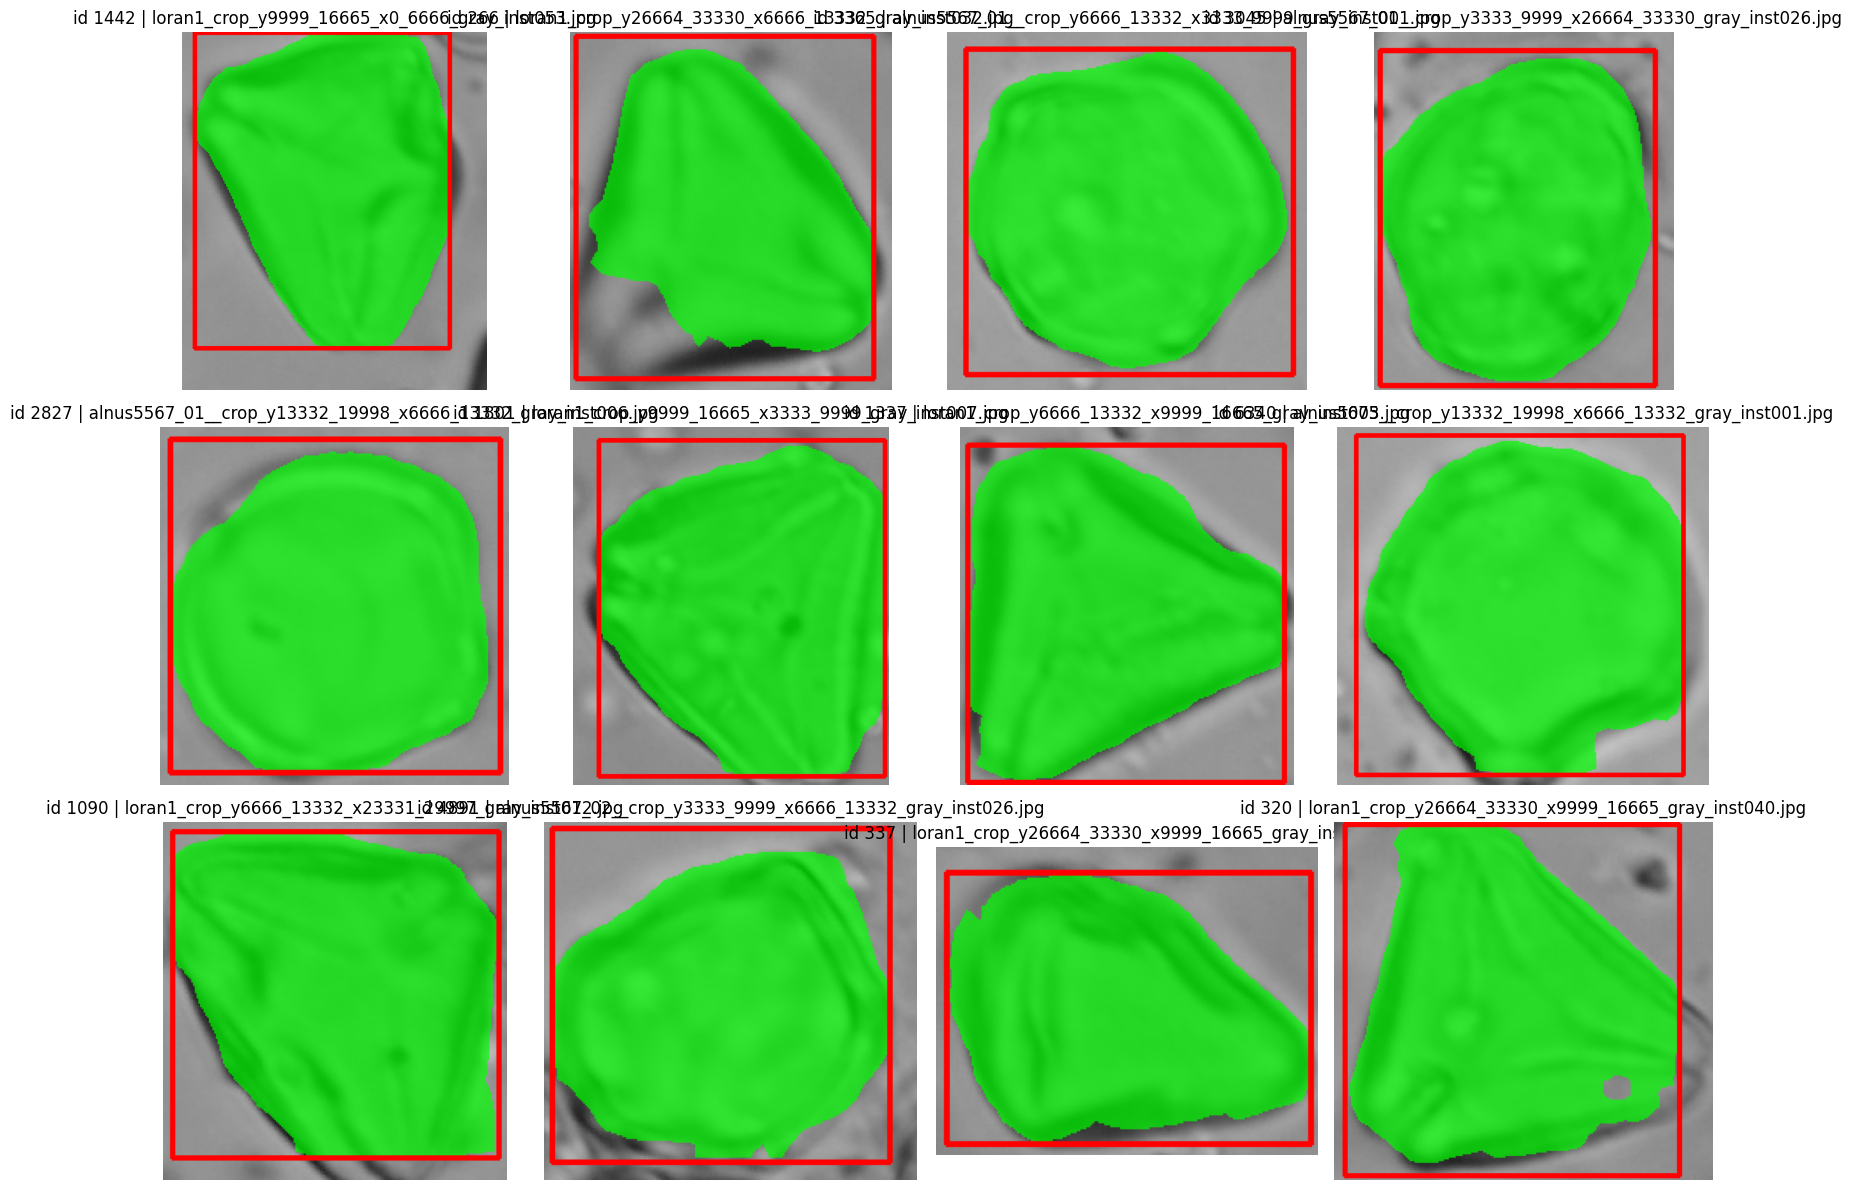

In [8]:
import matplotlib.pyplot as plt
import random

def show_samples(coco_json, k=12):
    with open(coco_json, "r") as f:
        data = json.load(f)
    anns_by_img = {}
    for an in data["annotations"]:
        anns_by_img.setdefault(an["image_id"], []).append(an)
    choices = [im for im in data["images"] if im["id"] in anns_by_img]
    if len(choices)==0:
        print("No annotated images to show."); return
    choices = random.sample(choices, k=min(k, len(choices)))
    cols = 4
    rows = int(np.ceil(len(choices)/cols))
    plt.figure(figsize=(4*cols, 4*rows))

    for idx, im in enumerate(choices):
        img = cv2.imread(im["file_name"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        overlay = img.copy()
        for an in anns_by_img[im["id"]]:
            rle = an["segmentation"]
            m = mask_util.decode(rle).astype(bool)
            overlay[m] = (overlay[m]*0.3 + np.array([0,255,0])*0.7).astype(np.uint8)
            x,y,w,h = an["bbox"]
            x2, y2 = int(x+w), int(y+h)
            cv2.rectangle(overlay, (int(x),int(y)), (x2,y2), (255,0,0), 2)
        plt.subplot(rows, cols, idx+1)
        plt.imshow(overlay); plt.axis("off")
        plt.title(f'id {im["id"]} | {os.path.basename(im["file_name"])}')

    plt.tight_layout()
    plt.show()


show_samples(os.path.join(OUT_ROOT, MASTER_JSON.replace(".json","_train.json")), k=12)

In [9]:
from google.colab import files
files.download(PKG_ZIP)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
# !pip -q install -U cython pycocotools
# !pip -q install 'git+https://github.com/facebookresearch/detectron2.git'

import os, json, glob, datetime, random
import numpy as np
import torch

print("CUDA available:", torch.cuda.is_available())

CUDA available: True


In [38]:
# === Paths (start of training phase) ===
import os, json
from datetime import datetime as _dt

ROOT = "/content/drive/MyDrive/pollen_segmentation"   # folder containing coco_thr001_top1_masks_*.json
RUN_DIR = "/content/drive/MyDrive/pollen_runs/maskrcnn_r50_3cls_thr001_top1_bal28_ms_warm"  # new output folder
os.makedirs(RUN_DIR, exist_ok=True)

train_json = os.path.join(ROOT, "coco_thr001_top1_masks_train.json")
val_json   = os.path.join(ROOT, "coco_thr001_top1_masks_val.json")
test_json  = os.path.join(ROOT, "coco_thr001_top1_masks_test.json")

# Basic sanity check
for p in [train_json, val_json, test_json]:
    assert os.path.isfile(p), f"Missing COCO file: {p}"

# === Ensure COCO 'info' / 'licenses' blocks exist (some tools require them) ===
_now = _dt.now().strftime("%Y-%m-%d %H:%M:%S")

def patch_coco_info(path):
    """
    Add minimal 'info' and 'licenses' sections to a COCO JSON if they are absent.
    This keeps downstream evaluators/viewers happy and records provenance.
    """
    with open(path, "r") as f:
        data = json.load(f)

    changed = False
    if "info" not in data:
        data["info"] = {
            "description": "Pseudo-labeled pollen masks (thr=0.01, top-1 per image)",
            "version": "1.0",
            "year": 2025,
            "contributor": "auto",
            "date_created": _now
        }
        changed = True

    if "licenses" not in data:
        data["licenses"] = []  # no specific license metadata available
        changed = True

    if changed:
        with open(path, "w") as f:
            json.dump(data, f)
        print("patched:", os.path.basename(path))
    else:
        print("ok:", os.path.basename(path))

for p in [train_json, val_json, test_json]:
    patch_coco_info(p)

# === Register datasets in Detectron2 ===
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# Clean up any previous registrations to avoid name collisions
for name in ["pollen_train", "pollen_val", "pollen_test"]:
    if name in DatasetCatalog.list():
        DatasetCatalog.remove(name)
        MetadataCatalog.remove(name)

# file_name fields in the JSON are absolute paths,
# so using image_root="/" is fine (Detectron2 will use the absolute file_name).
register_coco_instances("pollen_train", {}, train_json, "/")
register_coco_instances("pollen_val",   {}, val_json,   "/")
register_coco_instances("pollen_test",  {}, test_json,  "/")

print("registered:", DatasetCatalog.list())

ok: coco_thr001_top1_masks_train.json
ok: coco_thr001_top1_masks_val.json
ok: coco_thr001_top1_masks_test.json
registered: ['coco_2014_train', 'coco_2014_val', 'coco_2014_minival', 'coco_2014_valminusminival', 'coco_2017_train', 'coco_2017_val', 'coco_2017_test', 'coco_2017_test-dev', 'coco_2017_val_100', 'keypoints_coco_2014_train', 'keypoints_coco_2014_val', 'keypoints_coco_2014_minival', 'keypoints_coco_2014_valminusminival', 'keypoints_coco_2017_train', 'keypoints_coco_2017_val', 'keypoints_coco_2017_val_100', 'coco_2017_train_panoptic_separated', 'coco_2017_train_panoptic_stuffonly', 'coco_2017_train_panoptic', 'coco_2017_val_panoptic_separated', 'coco_2017_val_panoptic_stuffonly', 'coco_2017_val_panoptic', 'coco_2017_val_100_panoptic_separated', 'coco_2017_val_100_panoptic_stuffonly', 'coco_2017_val_100_panoptic', 'lvis_v1_train', 'lvis_v1_val', 'lvis_v1_test_dev', 'lvis_v1_test_challenge', 'lvis_v0.5_train', 'lvis_v0.5_val', 'lvis_v0.5_val_rand_100', 'lvis_v0.5_test', 'lvis_v0.5

In [39]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os, torch

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
))

# === Dataset & classes ===
cfg.DATASETS.TRAIN = ("pollen_train",)  # training set (COCO-style)
cfg.DATASETS.TEST  = ("pollen_val",)    # eval during training is on 'val' only
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3     # {alnus, carpinus, loranthus}
cfg.MODEL.MASK_ON = True
cfg.INPUT.MASK_FORMAT = "bitmask"       # using RLE/bitmask masks

# === Class imbalance mitigation ===
# Repeat rare classes more often according to frequency threshold τ
cfg.DATALOADER.SAMPLER_TRAIN = "RepeatFactorTrainingSampler"
cfg.DATALOADER.REPEAT_THRESHOLD = 0.02  # tune in [0.001, 0.1]

# === Small-object boost (sharper masks) ===
# Increase mask head pooler resolution (default 14 -> 28)
cfg.MODEL.ROI_MASK_HEAD.POOLER_RESOLUTION = 28

# === Light augmentation & multi-scale training ===
cfg.INPUT.MIN_SIZE_TRAIN = (640, 800, 1024)  # random choice each iteration
cfg.INPUT.MAX_SIZE_TRAIN = 1333
cfg.INPUT.RANDOM_FLIP = "horizontal"

# === Warm-start weights ===
# Prefer Teacher (Loranthus) weights; otherwise COCO-pretrained
loranthus_ckpt = "/content/drive/MyDrive/pollen_crops/model_final.pth"
if os.path.isfile(loranthus_ckpt):
    cfg.MODEL.WEIGHTS = loranthus_ckpt
else:
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
        "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
    )

# === Solver (training schedule) ===
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 2.5e-4
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.STEPS = (8000, 11000)   # step LR decay points
cfg.SOLVER.MAX_ITER = 18000
cfg.SOLVER.CHECKPOINT_PERIOD = 2000
cfg.SOLVER.WEIGHT_DECAY = 2e-4
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  # RoIs per image

# === Eval cadence ===
cfg.TEST.EVAL_PERIOD = 1000  # run COCO eval every N iters

# === Device & output ===
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cfg.OUTPUT_DIR = RUN_DIR
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

print("OUTPUT_DIR:", cfg.OUTPUT_DIR)

OUTPUT_DIR: /content/drive/MyDrive/pollen_runs/maskrcnn_r50_3cls_thr001_top1_bal28_ms_warm


In [40]:
from detectron2.engine import DefaultTrainer, hooks
from detectron2.evaluation import COCOEvaluator
from detectron2.checkpoint import DetectionCheckpointer
import os

# Custom trainer that builds a COCO evaluator (both bbox and segm)
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "eval", dataset_name)
        os.makedirs(output_folder, exist_ok=True)
        # Evaluate both bounding-box and mask metrics
        return COCOEvaluator(dataset_name, output_dir=output_folder, tasks=("bbox", "segm"))

trainer = MyTrainer(cfg)

# Resume from the latest checkpoint if present; otherwise start fresh
trainer.resume_or_load(resume=True)

# === BestCheckpointer ===
# Save the best-performing weights according to the chosen validation metric.
# Args: (eval_period, checkpointer, metric_name, mode, file_prefix)
best_metric = "segm/AP"
trainer.register_hooks([
    hooks.BestCheckpointer(
        cfg.TEST.EVAL_PERIOD,
        DetectionCheckpointer(trainer.model, save_dir=cfg.OUTPUT_DIR),
        best_metric,
        mode="max",
        file_prefix="model_best"
    )
])

# Ensure the BestCheckpointer runs AFTER evaluation (hook order fix)
trainer._hooks = trainer._hooks[:-1] + trainer._hooks[-1:]

# === Train ===
trainer.train()

[08/12 08:54:20 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[08/12 08:54:21 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/detectron2/data/detection_utils.py:449: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/usr/local/lib/python3.11/dist-packages/detectron2/data/detection_utils.py:449: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program

[08/12 08:54:44 d2.utils.events]:  eta: 5:58:22  iter: 19  total_loss: 2.569  loss_cls: 1.377  loss_box_reg: 0.1702  loss_mask: 0.6954  loss_rpn_cls: 0.2224  loss_rpn_loc: 0.09556    time: 1.1540  last_time: 1.2379  data_time: 0.0303  last_data_time: 0.0058   lr: 4.9953e-06  max_mem: 7336M
[08/12 08:55:07 d2.utils.events]:  eta: 5:59:30  iter: 39  total_loss: 2.022  loss_cls: 0.9861  loss_box_reg: 0.1678  loss_mask: 0.6831  loss_rpn_cls: 0.07464  loss_rpn_loc: 0.07058    time: 1.1554  last_time: 1.2177  data_time: 0.0199  last_data_time: 0.0058   lr: 9.9902e-06  max_mem: 7512M
[08/12 08:55:31 d2.utils.events]:  eta: 6:02:58  iter: 59  total_loss: 1.438  loss_cls: 0.4863  loss_box_reg: 0.1705  loss_mask: 0.6541  loss_rpn_cls: 0.06156  loss_rpn_loc: 0.09873    time: 1.1708  last_time: 1.2926  data_time: 0.0208  last_data_time: 0.0063   lr: 1.4985e-05  max_mem: 7512M
[08/12 08:55:55 d2.utils.events]:  eta: 6:04:19  iter: 79  total_loss: 1.153  loss_cls: 0.2459  loss_box_reg: 0.1583  loss_

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea29bcff60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea29bcff60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

[08/12 09:18:58 d2.utils.events]:  eta: 5:49:45  iter: 1159  total_loss: 0.2051  loss_cls: 0.02396  loss_box_reg: 0.04172  loss_mask: 0.09028  loss_rpn_cls: 0.0008788  loss_rpn_loc: 0.0409    time: 1.1986  last_time: 0.6474  data_time: 0.0215  last_data_time: 0.0072   lr: 0.00025  max_mem: 7516M
[08/12 09:19:21 d2.utils.events]:  eta: 5:49:24  iter: 1179  total_loss: 0.2177  loss_cls: 0.03024  loss_box_reg: 0.04609  loss_mask: 0.09522  loss_rpn_cls: 0.0005005  loss_rpn_loc: 0.03256    time: 1.1984  last_time: 0.8555  data_time: 0.0207  last_data_time: 0.0088   lr: 0.00025  max_mem: 7516M
[08/12 09:19:45 d2.utils.events]:  eta: 5:48:51  iter: 1199  total_loss: 0.2242  loss_cls: 0.02858  loss_box_reg: 0.04459  loss_mask: 0.1006  loss_rpn_cls: 0.002644  loss_rpn_loc: 0.04122    time: 1.1983  last_time: 1.2655  data_time: 0.0186  last_data_time: 0.0302   lr: 0.00025  max_mem: 7516M
[08/12 09:20:09 d2.utils.events]:  eta: 5:48:31  iter: 1219  total_loss: 0.2279  loss_cls: 0.02501  loss_box_

In [41]:
from detectron2.evaluation import inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.modeling import GeneralizedRCNNWithTTA
import glob

# ---- Pick checkpoint to evaluate: prefer best*, else model_final.pth ----
def _find_best_or_final(odir):
    bests = sorted(glob.glob(os.path.join(odir, "model_best*.pth")))
    if len(bests):
        return bests[-1]                      # latest "best" by your metric
    f = os.path.join(odir, "model_final.pth") # last iteration snapshot
    return f if os.path.isfile(f) else None

ckpt_path = _find_best_or_final(cfg.OUTPUT_DIR)
print("=> Loading for final eval:", ckpt_path)

# ---- Load weights into the current trainer model ----
checkpointer = DetectionCheckpointer(trainer.model)
if ckpt_path:
    checkpointer.load(ckpt_path)

# ================== No-TTA evaluation ==================
# Build a test loader for 'pollen_val' and run COCOEvaluator (bbox + segm)
val_loader = build_detection_test_loader(cfg, "pollen_val")
val_eval   = COCOEvaluator(
    "pollen_val",
    output_dir=os.path.join(cfg.OUTPUT_DIR, "eval_val"),
    tasks=("bbox", "segm")
)
print("== Val (no TTA) ==")
val_res = inference_on_dataset(trainer.model, val_loader, val_eval)
print(val_res)  # dict with keys like {'bbox': {...}, 'segm': {...}}

# Build a test loader for 'pollen_test' and evaluate
test_loader = build_detection_test_loader(cfg, "pollen_test")
test_eval   = COCOEvaluator(
    "pollen_test",
    output_dir=os.path.join(cfg.OUTPUT_DIR, "eval_test"),
    tasks=("bbox", "segm")
)
print("== Test (no TTA) ==")
test_res = inference_on_dataset(trainer.model, test_loader, test_eval)
print(test_res)

# ================== TTA evaluation ==================
# Wrap the trained model with test-time augmentation (flip/scale ensemble).
# Note: TTA is slower and not always better; compare against no-TTA.
tta_model = GeneralizedRCNNWithTTA(cfg, trainer.model)

print("== Val (TTA) ==")
val_res_tta = inference_on_dataset(
    tta_model,
    val_loader,
    COCOEvaluator(
        "pollen_val",
        output_dir=os.path.join(cfg.OUTPUT_DIR, "eval_val_tta"),
        tasks=("bbox", "segm")
    )
)
print(val_res_tta)

print("== Test (TTA) ==")
test_res_tta = inference_on_dataset(
    tta_model,
    test_loader,
    COCOEvaluator(
        "pollen_test",
        output_dir=os.path.join(cfg.OUTPUT_DIR, "eval_test_tta"),
        tasks=("bbox", "segm")
    )
)
print(test_res_tta)

# Notes:
# - Each COCOEvaluator writes raw results (e.g., coco_instances_results.json),
#   summary text, and metrics to its output_dir (eval_val, eval_test, ...).
# - The printed dicts (val_res, test_res, ...) contain AP/AP50/AP75 and, if
#   available, per-class AP (keys like 'AP-alnus', etc.).

=> Loading for final eval: /content/drive/MyDrive/pollen_runs/maskrcnn_r50_3cls_thr001_top1_bal28_ms_warm/model_best.pth
[08/12 15:09:44 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/pollen_runs/maskrcnn_r50_3cls_thr001_top1_bal28_ms_warm/model_best.pth ...
[08/12 15:09:44 d2.data.datasets.coco]: Loaded 790 images in COCO format from /content/drive/MyDrive/pollen_segmentation/coco_thr001_top1_masks_val.json
[08/12 15:09:44 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/12 15:09:44 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/12 15:09:44 d2.data.common]: Serializing 790 elements to byte tensors and concatenating them all ...
[08/12 15:09:44 d2.data.common]: Serialized dataset takes 0.44 MiB
== Val (no TTA) ==
[08/12 15:09:44 d2.evaluation.evaluator]: Start in

In [44]:
# ---- Visualization (no TTA, using DefaultPredictor) ----
import cv2, os, random
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog

# 1) Build an inference cfg (load the same best/final weights used in eval)
cfg_pred = cfg.clone()
cfg_pred.MODEL.WEIGHTS = ckpt_path          # best/final checkpoint chosen above
cfg_pred.DATASETS.TEST = ("pollen_val",)    # for metadata lookup
cfg_pred.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # adjust if needed
predictor = DefaultPredictor(cfg_pred)

# 2) Metadata and output folder
meta = MetadataCatalog.get("pollen_val")
save_dir = os.path.join(cfg.OUTPUT_DIR, "viz_val")
os.makedirs(save_dir, exist_ok=True)

# 3) Sample N random images from the val set and save overlaid predictions
N = 16
dataset_dicts = DatasetCatalog.get("pollen_val")
ids = list(range(len(dataset_dicts)))
random.shuffle(ids)
ids = ids[:min(N, len(ids))]

for i in ids:
    d = dataset_dicts[i]
    img = cv2.imread(d["file_name"])
    if img is None:
        continue  # (optional) skip if the image cannot be read

    # Run inference (no TTA)
    outputs = predictor(img)

    # Visualize instance predictions
    v = Visualizer(img[:, :, ::-1], metadata=meta, scale=1.0,
                   instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    out_img = out.get_image()[:, :, ::-1]

    # Save visualization next to other run artifacts
    out_path = os.path.join(save_dir, f"val_{os.path.basename(d['file_name'])}")
    cv2.imwrite(out_path, out_img)

print("Saved visualizations to:", save_dir)

[08/12 16:28:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/pollen_runs/maskrcnn_r50_3cls_thr001_top1_bal28_ms_warm/model_best.pth ...
[08/12 16:28:50 d2.data.datasets.coco]: Loaded 790 images in COCO format from /content/drive/MyDrive/pollen_segmentation/coco_thr001_top1_masks_val.json
Saved visualizations to: /content/drive/MyDrive/pollen_runs/maskrcnn_r50_3cls_thr001_top1_bal28_ms_warm/viz_val


In [45]:
import pandas as pd
from collections import OrderedDict

def pick(metrics_dict):
    """
    Pull the key fields from a Detectron2 COCOEvaluator result dict.
    Returns a flat OrderedDict with:
      - overall AP/AP50/AP75 for segm & bbox
      - per-class AP (e.g., segm/AP-alnus)
    """
    out = OrderedDict()
    for head in ["segm", "bbox"]:
        if head in metrics_dict:
            sec = metrics_dict[head]
            # overall APs
            out[f"{head}/AP"]   = sec.get("AP", None)
            out[f"{head}/AP50"] = sec.get("AP50", None)
            out[f"{head}/AP75"] = sec.get("AP75", None)
            # per-class APs
            for k, v in sec.items():
                if k.startswith("AP-"):
                    out[f"{head}/{k}"] = v
    return out

# Collect rows for each split/result bundle
rows = []
rows.append(("val_noTTA",  pick(val_res)))
rows.append(("test_noTTA", pick(test_res)))
rows.append(("val_TTA",    pick(val_res_tta)))
rows.append(("test_TTA",   pick(test_res_tta)))

# Union of all keys so columns align across splits
all_keys = sorted(set().union(*[set(r[1].keys()) for r in rows]))
table = []
for name, d in rows:
    row = {"split": name}
    for k in all_keys:
        row[k] = d.get(k, None)
    table.append(row)

# Build dataframe indexed by split
df = pd.DataFrame(table).set_index("split")

# Add TTA deltas (TTA - noTTA) for segm/AP and bbox/AP
for head in ["segm", "bbox"]:
    col = f"{head}/AP"
    if col in df.columns and "val_noTTA" in df.index and "val_TTA" in df.index:
        df.loc["val_Δ(TTA-noTTA)", col] = df.loc["val_TTA", col] - df.loc["val_noTTA", col]
    if col in df.columns and "test_noTTA" in df.index and "test_TTA" in df.index:
        df.loc["test_Δ(TTA-noTTA)", col] = df.loc["test_TTA", col] - df.loc["test_noTTA", col]

# Print a compact view:
#   - overall AP/AP50/AP75 for both segm/bbox
#   - per-class AP for segm (e.g., segm/AP-alnus)
cols_to_show = [
    c for c in df.columns
    if (c.endswith("/AP") or c.endswith("/AP50") or c.endswith("/AP75"))
       or ("/AP-" in c and "segm" in c)
]
print(df[cols_to_show].round(3))

# Save CSV alongside other run artifacts
csv_path = os.path.join(cfg.OUTPUT_DIR, "eval_summary.csv")
df.to_csv(csv_path)
print("== saved summary:", csv_path)

                   bbox/AP  bbox/AP50  bbox/AP75  segm/AP  segm/AP-alnus  \
split                                                                      
val_noTTA           59.259     73.971     69.075   62.999         81.244   
test_noTTA          60.856     74.852     70.807   65.314         82.857   
val_TTA             57.185     71.429     66.810   61.118         80.197   
test_TTA            59.106     72.789     68.023   62.613         80.373   
val_Δ(TTA-noTTA)    -2.074        NaN        NaN   -1.881            NaN   
test_Δ(TTA-noTTA)   -1.750        NaN        NaN   -2.701            NaN   

                   segm/AP-carpinus  segm/AP-loranthus  segm/AP50  segm/AP75  
split                                                                         
val_noTTA                    50.943             56.811     73.980     69.154  
test_noTTA                   55.133             57.950     75.046     71.707  
val_TTA                      47.775             55.382     71.529     66.68

In [52]:
# ---- 5) Final one-stop table: merge summary + COCO(AP/AR/size) + extras (avoid column collisions) ----
summary_csv = os.path.join(cfg.OUTPUT_DIR, "eval_summary.csv")

parts = {}

# (a) Base summary (the CSV created in the previous cell)
if os.path.isfile(summary_csv):
    base = pd.read_csv(summary_csv).set_index("split")
    # drop any duplicate columns if re-run
    base = base.loc[:, ~base.columns.duplicated()]
    parts["summary"] = base
else:
    # if missing, keep an empty frame (so concat still works)
    parts["summary"] = pd.DataFrame()

# (b) COCO AP/AR by size (from COCOeval.stats recovery)
if "df_stats" in locals():
    df_stats = df_stats.loc[:, ~df_stats.columns.duplicated()]
    parts["coco"] = df_stats

# (c) Per-class AP table (if available)
if "df_pc" in locals():
    parts["per_class_AP"] = df_pc.loc[:, ~df_pc.columns.duplicated()]

# (d) Dataset distribution (images & instances per split/class)
if "df_dist" in locals():
    parts["dataset_distribution"] = df_dist.loc[:, ~df_dist.columns.duplicated()]

# (e) Inference speed (if measured)
if "spd" in locals():
    df_spd = pd.DataFrame([spd], index=["inference"])
    parts["speed"] = df_spd

# Use a MultiIndex on columns to avoid name collisions across sections
final = pd.concat(parts, axis=1)

# Nicely ordered & saved (hierarchical columns)
final = final.sort_index()
merged_csv = os.path.join(report_dir, "final_summary_merged.csv")
final.round(3).to_csv(merged_csv)

# Also save a flat, Excel-friendly version of the same table
flat = final.copy()
flat.columns = [f"{sec}:{col}" for sec, col in flat.columns]
flat_csv = os.path.join(report_dir, "final_summary_flat.csv")
flat.round(3).to_csv(flat_csv)

print("saved:", merged_csv)
print("saved:", flat_csv)

# Quick presence check for the main report files
print("\n== Report files ==")
for fn in [
    "coco_ap_ar_sizes.csv",
    "per_class_AP.csv",
    "dataset_distribution.csv",
    "inference_speed.txt",
    "final_summary_merged.csv",
    "final_summary_flat.csv",
]:
    p = os.path.join(report_dir, fn)
    print(fn, "->", "OK" if os.path.exists(p) else "MISSING")

saved: /content/drive/MyDrive/pollen_runs/maskrcnn_r50_3cls_thr001_top1_bal28_ms_warm/report/final_summary_merged.csv
saved: /content/drive/MyDrive/pollen_runs/maskrcnn_r50_3cls_thr001_top1_bal28_ms_warm/report/final_summary_flat.csv

== Report files ==
coco_ap_ar_sizes.csv -> OK
per_class_AP.csv -> OK
dataset_distribution.csv -> OK
inference_speed.txt -> OK
final_summary_merged.csv -> OK
final_summary_flat.csv -> OK


In [53]:
# === Eval 결과 ZIP 묶고 다운로드 ===
import os, shutil, time, json, glob
from pathlib import Path

# 1) 경로 설정: 이미 위에서 cfg.OUTPUT_DIR/RUN_DIR를 썼다면 그대로 사용
RUN_DIR = Path(cfg.OUTPUT_DIR)  # 예: /content/drive/MyDrive/pollen_runs/...

# 2) 포함할 후보들 (있으면 자동 포함)
candidates = [
    RUN_DIR / "eval_summary.csv",
    RUN_DIR / "metrics.json",
    RUN_DIR / "cfg.yaml",
    RUN_DIR / "inference_speed.txt",
    RUN_DIR / "report" / "inference_speed.txt",
    RUN_DIR / "viz_val",
    RUN_DIR / "viz_test",
    RUN_DIR / "eval_val",
    RUN_DIR / "eval_test",
    RUN_DIR / "eval_val_tta",
    RUN_DIR / "eval_test_tta",
    RUN_DIR / "eval" / "pollen_val",
    RUN_DIR / "eval" / "pollen_test",
]

# (옵션) 가중치도 넣고 싶으면 True로 변경
INCLUDE_WEIGHTS = True
if INCLUDE_WEIGHTS:
    candidates += list(RUN_DIR.glob("model_best*.pth")) + [RUN_DIR / "model_final.pth"]

# 3) 존재하는 것만 골라서 번들 폴더에 복사
stamp = time.strftime("%Y%m%d_%H%M%S")
bundle_dir = RUN_DIR / f"export_bundle_{stamp}"
bundle_dir.mkdir(parents=True, exist_ok=True)

included = []
for p in candidates:
    if not p.exists():
        continue
    dst = bundle_dir / p.name
    try:
        if p.is_dir():
            shutil.copytree(p, dst)
        else:
            shutil.copy2(p, dst)
        included.append(str(p))
    except Exception as e:
        print(f"[skip] {p} -> {e}")

# 4) README 추가
readme = bundle_dir / "README.txt"
with open(readme, "w") as f:
    f.write(
        "Pollen segmentation evaluation bundle\n"
        f"- created at: {stamp}\n"
        f"- run_dir: {RUN_DIR}\n\n"
        "Included:\n" + "\n".join(f"  - {x}" for x in included) + "\n"
        "\nfiles:\n"
        "  * eval_summary.csv        : split별 COCO AP 요약\n"
        "  * metrics.json            : Detectron2 학습 로그\n"
        "  * cfg.yaml                : 최종 학습/추론 설정\n"
        "  * inference_speed.txt     : (있다면) 추론 속도 결과\n"
        "  * viz_val/, viz_test/     : 시각화 이미지\n"
        "  * eval_*/, eval/*         : COCOEvaluator 원본 산출물\n"
        "  * (선택) model_best*.pth  : 최고 성능 가중치\n"
    )

# 5) ZIP 생성
zip_path = shutil.make_archive(str(bundle_dir), "zip", root_dir=str(bundle_dir))
print("ZIP saved to:", zip_path)

# 6) 코랩에서 바로 다운로드
try:
    from google.colab import files
    files.download(zip_path)
except Exception as e:
    print("Colab download failed (환경에 따라 정상):", e)
    print("수동 다운로드 경로:", zip_path)

ZIP saved to: /content/drive/MyDrive/pollen_runs/maskrcnn_r50_3cls_thr001_top1_bal28_ms_warm/export_bundle_20250812_165851.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>